In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [252]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import chardet
import ast
import re
from gensim.parsing.preprocessing import remove_stopwords

import collections 
import itertools
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Activation, Dense,Dropout
from scipy.sparse import csr_matrix


In [97]:
reviews_train =  pd.read_csv(r"./drive/MyDrive/datasets/Computation-Intelligence/project2/train.csv")
reviews_test =  pd.read_csv(r"./drive/MyDrive/datasets/Computation-Intelligence/project2/test.csv")

In [98]:
np.set_printoptions(suppress=True)

# **PART 0 -- PREPROCESSING**

In [99]:

reviews_train = reviews_train.drop('Unnamed: 3', 1)
reviews_test = reviews_test.drop('Unnamed: 3', 1)
reviews_test = reviews_test.drop('Unnamed: 4', 1)

reviews = reviews_train.append(reviews_test) #appending both the datasets at 
reviews = reviews.reset_index(drop=True) 

'''removing rows with na values'''
reviews = reviews.dropna() #843 978 1755 1961 have values for "Unnamed: 3" 

'''removing rows with no text for overview'''
reviews = reviews[reviews['overview'].str.contains('[A-Za-z]')]

In [100]:
reviews.shape

(2990, 3)

In [101]:
reviews.tail()

,id,genres,overview
2995,2996,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",Military men Rock Reilly and Eddie Devane are ...
2996,2997,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",Three girls in 1980s Stockholm decide to form ...
2997,2998,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...","Samantha Caine, suburban homemaker, is the ide..."
2998,2999,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",Reuben Feffer is a guy who's spent his entire ...
2999,3000,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",A young man sets out to uncover the truth abou...


In [102]:
'''MODIFYING GENRES FOR REVIEWS'''

for index, row in reviews.iterrows():
  genres = ast.literal_eval(row['genres'])
  st = '' 
  for genre in genres:
    st += f"{genre['name']},"
  st = st[0:-1] 
  reviews.loc[index,'genres'] = st


In [103]:
reviews.head()

,id,genres,overview
0,1,Comedy,"When Lou, who has become the ""father of the In..."
1,2,"Comedy,Drama,Family,Romance",Mia Thermopolis is now a college graduate and ...
2,3,Drama,"Under the direction of a ruthless instructor, ..."
3,4,"Thriller,Drama",Vidya Bagchi (Vidya Balan) arrives in Kolkata ...
4,5,"Action,Thriller",Marine Boy is the story of a former national s...


**Finding movie by genre popularity in dataset**

In [104]:
genre_count = collections.Counter(itertools.chain.from_iterable(v.split(',') for v in reviews.genres))

genre_count_df = pd.DataFrame({'Genre': list(genre_count.keys()), 
                              'Count': list(genre_count.values())})

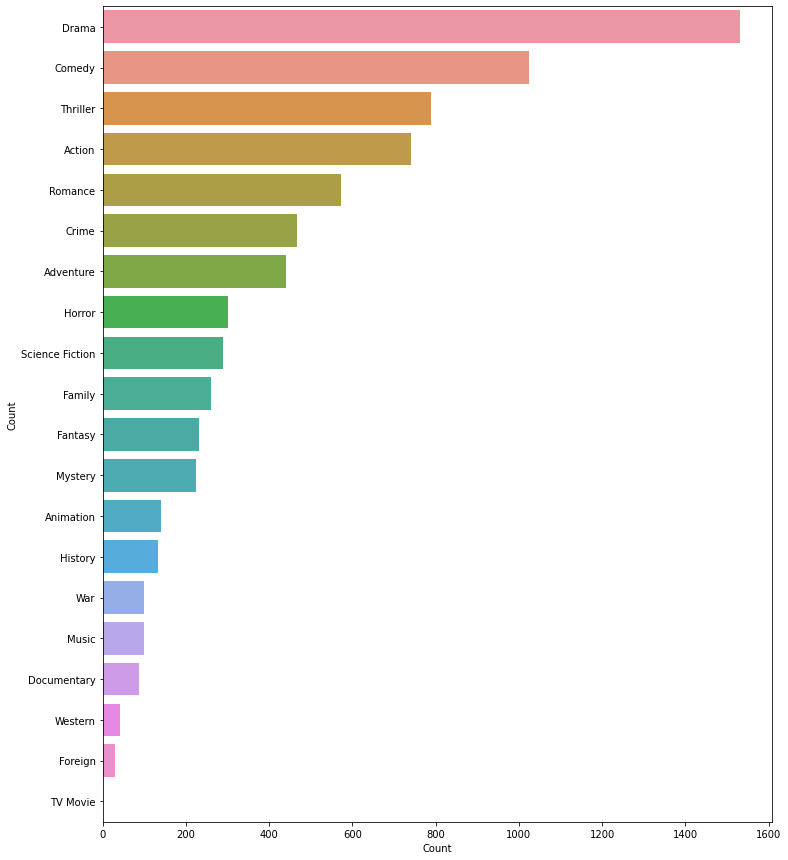

In [105]:
g = genre_count_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [106]:
y_dummy = reviews['genres'].str.get_dummies(sep=',')

y_dummy.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [107]:
y = y_dummy.values

In [108]:
y.shape

(2990, 20)

in this section, we will clean up the overview part of the input of our problem

In [109]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text



def final_clean(text):
      return gensim.utils.simple_preprocess (text)


In [118]:
X = reviews['overview']

X = X.apply(lambda x: clean_text(x))

X = X.apply(remove_stopwords)


In [111]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(reviews['genres'].str.split(',')) #THIS WILL BE USED FOR INVERSE TRANSFORM

#multilabel_binarizer.inverse_transform(y)[3]

MultiLabelBinarizer(classes=None, sparse_output=False)

In [116]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.333, random_state=9) #taking back around 1000 for test set

In [117]:
print(xtest.shape)
print(xtrain.shape) #2003 inputs, each having 1 sentence 
xtrain[1]

(996,)
(1994,)


'mia thermopolis college graduate way genovia duties princess best friend lilly joins summer mia continues princess lessons riding horses saddle archery royal complicated life turned upside learns crown queen earlier expected'

In [119]:
print("**** Y TRAIN HEAD ****\n")
print(*multilabel_binarizer.inverse_transform(ytrain)[0:20],sep='\n')
print("\n")
print(f"{(ytrain)[0:20]}\n\n\n\n\n")

print("**** Y TEST HEAD ****")
print(*multilabel_binarizer.inverse_transform(ytest)[0:20],sep='\n')
print("\n")
print((ytest)[0:20])

**** Y TRAIN HEAD ****

('Action', 'Crime', 'Thriller')
('Comedy', 'Drama')
('Comedy',)
('Action', 'Comedy', 'Crime', 'Thriller')
('Action', 'Comedy', 'Crime')
('Action', 'Adventure', 'Horror')
('Mystery', 'Thriller')
('Action', 'Adventure', 'Science Fiction', 'Thriller')
('Crime', 'Drama', 'Thriller')
('Drama',)
('Comedy', 'Music')
('Adventure', 'Family', 'Fantasy', 'Music')
('Drama', 'Horror', 'Thriller')
('Documentary',)
('Drama', 'Romance')
('Horror', 'Thriller')
('Drama', 'History')
('Action', 'Adventure', 'Science Fiction')
('Comedy', 'Drama', 'Romance')
('Action', 'Drama', 'History', 'Thriller')


[[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 

# **PART1 -- WORD2VEC**

In [160]:
SIZE = 150
WINDOW = 15

In [161]:
#note that since Word2Vec is considered an 'unsupervised' algorithm, so at 
#least during its training, it is not typical to hold back any 'test' data for
#later evaluation.
x_w2v = X.apply(lambda x: final_clean(x))
w2v_model = gensim.models.Word2Vec (x_w2v, size=SIZE, window=WINDOW, min_count=2, workers=10)
w2v_model.train(x_w2v,total_examples=len(x_w2v),epochs=100)



(7425240, 8373900)

In [122]:
w1 = "death"
w2v_model.wv.most_similar (positive=w1)

[('hunters', 0.31414371728897095),
 ('avenge', 0.29827970266342163),
 ('survives', 0.2917688190937042),
 ('key', 0.28799381852149963),
 ('reclusive', 0.26812446117401123),
 ('clay', 0.2647029459476471),
 ('witness', 0.26030513644218445),
 ('phillips', 0.2592740058898926),
 ('bars', 0.2579519748687744),
 ('yearning', 0.25779426097869873)]

below, we find the feature values for each document by summing over the word features then dividing by the number of words

In [162]:
x_vec_w2v = np.zeros((len(x_w2v), SIZE))

for idx, paragraph in enumerate(x_w2v): 
  ln = len(paragraph)
  arr = np.zeros(SIZE)
  for word in paragraph:
    try:
      arr = w2v_model[word] + arr
  
    except KeyError:
      ln -= 1
  arr = arr/ln 
  x_vec_w2v[idx,:] = arr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [163]:
xtrain_w2v, xtest_w2v, ytrain_w2v, ytest_w2v = train_test_split(x_vec_w2v, y, test_size=0.333, random_state=9) #now do splitting for classification
                                #note that since parameters same as split above, the y's will be the same as before (ytrain_w2v == ytrain)

----------

**LOGISTIC REGRESSION WITH 1VSALL**

In [255]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(xtrain_w2v, ytrain_w2v)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [256]:
y_pred_prob_trn = clf.predict_proba(xtrain_w2v)
y_pred_prob_tst = clf.predict_proba(xtest_w2v)

t = 0.25752 # threshold value
y_pred_lr_trn = (y_pred_prob_trn >= t).astype(int)
y_pred_lr_tst = (y_pred_prob_tst >= t).astype(int)


In [257]:
nm = 3
print(f"Real value: {multilabel_binarizer.inverse_transform(ytest_w2v)[nm]}")
print(f"predicted value: {multilabel_binarizer.inverse_transform(y_pred_lr_tst)[nm]}")

Real value: ('Action', 'Drama', 'Thriller')
predicted value: ('Action', 'Adventure', 'Drama', 'Thriller')


In [260]:
print("*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***")
print(f"test set prediction f-score: {f1_score(ytest, y_pred_lr_tst, average='micro')}")
print(f"test set prediction roc_auc-score: {roc_auc_score(ytest, y_pred_lr_tst, average='micro')}")

*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***
test set prediction f-score: 0.5618092161197076
test set prediction roc_auc-score: 0.784011809333782


**NEURAL NETWORK**

In [168]:
NUM_HIDDEN_LAYERS = 1
LAYER_SIZE = 145

In [169]:
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dropout(0.2,input_dim=n_inputs))
  model.add(Dense(LAYER_SIZE, kernel_initializer='he_uniform', activation='tanh'))
  for _ in range (NUM_HIDDEN_LAYERS-1):
    model.add(Dense(int(LAYER_SIZE), kernel_initializer='he_uniform', activation='tanh'))
  model.add(Dense(n_outputs, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics='accuracy')
  return model
 

x_train, y_train = xtrain_w2v, ytrain_w2v
n_inputs, n_outputs = x_train.shape[1], y_train.shape[1]

model = get_model(n_inputs, n_outputs)
history = model.fit(x_train, y_train, verbose=0, epochs=200, validation_split=0.1)


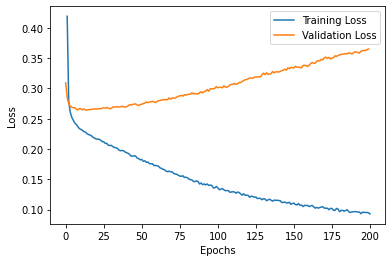

In [170]:
loss_values = history.history['loss']
vlloss_values = history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(vlloss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [273]:
model = get_model(n_inputs, n_outputs)
model.fit(x_train, y_train, verbose=0, epochs=12)

In [274]:
'''finding best threshold for the NN result'''
thresh =0.0
for _ in range (10):
  nn_y_pred = model.predict(xtest_w2v) 
  nn_y_pred = (nn_y_pred> thresh).astype(int)
  print(f"threshold: {thresh} --- score: {f1_score(ytest, nn_y_pred, average='micro')}")
  thresh += 0.05

threshold: 0.0 --- score: 0.22063421170165254
threshold: 0.05 --- score: 0.4442275788035523
threshold: 0.1 --- score: 0.5142574990741884
threshold: 0.15000000000000002 --- score: 0.5546751188589539
threshold: 0.2 --- score: 0.5701357466063348
threshold: 0.25 --- score: 0.5760620482989599
threshold: 0.3 --- score: 0.5704506560182544
threshold: 0.35 --- score: 0.5615258408531583
threshold: 0.39999999999999997 --- score: 0.543231441048035
threshold: 0.44999999999999996 --- score: 0.5208673350431335


we see that around 0.25 show the best threshold

In [275]:
nn_y_pred_trn = model.predict(xtrain_w2v)
nn_y_pred_tst = model.predict(xtest_w2v)

THRESHOLD = 0.25
nn_y_pred_trn = (nn_y_pred_trn >= THRESHOLD).astype(int)
nn_y_pred_tst = (nn_y_pred_tst >= THRESHOLD).astype(int)

In [276]:
print("*** NUERAL NET CLASSIFIER ***")
print(f"test set prediction f-score: {f1_score(ytest_w2v, nn_y_pred_tst, average='micro')}")
print(f"test set prediction roc-auc-score: {roc_auc_score(ytest_w2v, nn_y_pred_tst, average='micro')}")

*** NUERAL NET CLASSIFIER ***
test set prediction f-score: 0.5760620482989599
test set prediction roc-auc-score: 0.7858122107119241


# **PART 2 -- TFIDF**

In [245]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [246]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain) #Learn vocabulary and idf, return document-term matrix (each cell of each document is an idf weight)
xtest_tfidf = tfidf_vectorizer.transform(xtest)

csr_matrix.sort_indices(xtrain_tfidf)
csr_matrix.sort_indices(xtest_tfidf)

In [247]:
xtrain_tfidf.shape #each document shown with maximum 10000 weights (which comes from the TFIDF of each word in it)

(1994, 10000)

**LOGISTIC REGRESSION WITH 1VSALL**

In [267]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [268]:
y_pred_prob_trn = clf.predict_proba(xtrain_tfidf)
y_pred_prob_tst = clf.predict_proba(xtest_tfidf)

t = 0.23 # threshold value
y_pred_lr_trn = (y_pred_prob_trn >= t).astype(int)
y_pred_lr_tst = (y_pred_prob_tst >= t).astype(int)

In [269]:
nm = 3
print(f"Real value: {multilabel_binarizer.inverse_transform(ytest)[nm]}")
print(f"predicted value: {multilabel_binarizer.inverse_transform(y_pred_lr_tst)[nm]}")

Real value: ('Action', 'Drama', 'Thriller')
predicted value: ('Action', 'Drama', 'Thriller')


In [272]:
print("*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***")
print(f"test set f-score: {f1_score(ytest, y_pred_lr_tst, average='micro')}")
print(f"test set roc-auc-score: {roc_auc_score(ytest, y_pred_lr_tst, average='micro')}")

*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***
test set f-score: 0.5342008088623176
test set roc-auc-score: 0.7588365834135703


There appears to be a tradeoff betweeen between the threshold val and the training set & test set. IE: training set score goes up, test set score goes down

**NEURAL NETWORK**

In [277]:
NUM_HIDDEN_LAYERS = 1
LAYER_SIZE = 145

In [278]:
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dropout(0.2,input_dim=n_inputs))
  model.add(Dense(LAYER_SIZE, kernel_initializer='he_uniform', activation='tanh'))
  for _ in range (NUM_HIDDEN_LAYERS-1):
    model.add(Dense(int(LAYER_SIZE), kernel_initializer='he_uniform', activation='tanh'))
  model.add(Dense(n_outputs, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics='accuracy')
  return model
 

x_train, y_train = xtrain_tfidf.toarray(), ytrain
n_inputs, n_outputs = x_train.shape[1], y_train.shape[1]

model = get_model(n_inputs, n_outputs)
history= model.fit(x_train, y_train, verbose=0, epochs=50,validation_split = 0.1)

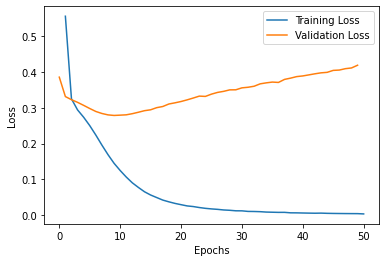

In [279]:
loss_values = history.history['loss']
vlloss_values = history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(vlloss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

the above plot shows that we have to early stop on around 9 epochs to get best result

In [280]:
model = get_model(n_inputs, n_outputs)
model.fit(x_train, y_train, verbose=0, epochs=9)

In [281]:
'''finding best threshold for the NN result'''
thresh =0.0
for _ in range (10):
  nn_y_pred = model.predict(xtest_tfidf) 
  nn_y_pred = (nn_y_pred> thresh).astype(int)
  print(f"threshold: {thresh} --- score: {f1_score(ytest, nn_y_pred, average='micro')}")
  thresh += 0.05

threshold: 0.0 --- score: 0.22063421170165254
threshold: 0.05 --- score: 0.41091667422250433
threshold: 0.1 --- score: 0.51473981030505
threshold: 0.15000000000000002 --- score: 0.5504845264145045
threshold: 0.2 --- score: 0.5704614288259398
threshold: 0.25 --- score: 0.5640520299566417
threshold: 0.3 --- score: 0.5520788684097728
threshold: 0.35 --- score: 0.5219003476245656
threshold: 0.39999999999999997 --- score: 0.4916479680877586
threshold: 0.44999999999999996 --- score: 0.45386666666666675


0.2 seems to be giving the best value!

In [300]:
nn_y_pred_trn = model.predict(xtrain_tfidf)
nn_y_pred_tst = model.predict(xtest_tfidf)

THRESHOLD = 0.2
nn_y_pred_trn = (nn_y_pred_trn >= THRESHOLD).astype(int)
nn_y_pred_tst = (nn_y_pred_tst >= THRESHOLD).astype(int)

In [301]:
print("*** NUERAL NET CLASSIFIER ***")
print(f"test set f-score: {f1_score(ytest, nn_y_pred_tst, average='micro')}")
print(f"test set roc-auc-score: {roc_auc_score(ytest, nn_y_pred_tst, average='micro')}")

*** NUERAL NET CLASSIFIER ***
test set f-score: 0.5704614288259398
test set roc-auc-score: 0.7799056877370858


# **PART 2.5 -- Discussing the obtained results**

In the above two parts, we built two classifiers for each of the secions. One Logistic Regression classifier using the 1vsAll method, and the other classifier is a neural network that can handle multi-label data. 

the result scores we obtained for Word2Vec & TF-IDF are fairly similar. with the F1 Metric giving scors around 56%. However, the way the algorithms themselves are able to achieve these scores is vastly differently:

**1- TF-IDF** is a word-document mapping. It ignores the order of words and gives NxM matrix where N is number of words in the vocabulary(which we specify the max number for scikit's implementation) and M is number of documents, and each cell has the weights of each of the words in its respective documents which is obtained from straightforward linear algebra.
TF-IDF can be used either for assigning vectors to words or to documents.

**2- Word2Vec** on the other hand gives a unique vector for each word based on the words appearing around the particular word, the word vector is obtained from the hidden layer of a two layered neural network. Word2Vec can be directly used to assign vector to a word but to get the vector representation of a document further processing is needed.

In order to find the document(or in our case "review") vectors for Word2Vec, we summed over the entire review's words' vectors, and then divided the result by the number of words. The pro of using this method is that we're taking into account the ordering of the words in each of document, the con of using this method is that all the words are treated with the same value, whereas in reality some words may be more important than others!

TF-IDF itself has a metric for finding word weights, both based on the review it is in (the "TF" AKA "Term Frequency" part) and based on taking into consideration the entire reviews (the "IDF" AKA "Inverse Document Frequency" part). This weight is good since we are able to identify how important a word is, but the problem with this algorithm is it doesn't take into consideration the ordering of the words. 

Now..What if we find a way to have the best of both worlds?

We can first use Word2Vec to find vector encodings for each of the words. after that, in the step of finding the average of the words used in the documents, we instead use the weighted average of the words in the document, Where we found  the weights of the words by using the TF-IDF method. This seems like a plausible way to mix both of methods above. which brings us to the next part..

# **PART 3 -- Combining TF-IDF and W2V to get better results!**

In [303]:
tfidf = TfidfVectorizer(max_df=0.8, max_features=10000)


In [304]:
# create TF-IDF features
tfidf.fit_transform(X)
dct= dict(zip(tfidf.get_feature_names(), tfidf.idf_)) #this is the dict we'll use to get the weights of words found with tfidf

In [305]:
SIZE = 150
WINDOW = 15

In [306]:
x_tfw2v = X.apply(lambda x: final_clean(x))
w2v_model = gensim.models.Word2Vec (x_tfw2v, size=SIZE, window=WINDOW, min_count=2, workers=10)
w2v_model.train(x_tfw2v,total_examples=len(x_tfw2v),epochs=55)

(4083689, 4605645)

In [307]:
x_vec_tfw2v = np.zeros((len(x_w2v), SIZE))

for idx, paragraph in enumerate(x_w2v): 
  weight_sum =0
  arr = np.zeros(SIZE)
  for word in paragraph:
    try:
      #Here we're taking the weighted average (the weights coming from tfidf) in order to mix the algorithms. 
      #words with higher weight will be taken more into consideration
      arr += w2v_model[word] * dct[word]
      weight_sum += dct[word]
    except KeyError:
      pass 
  arr = arr/weight_sum 
  x_vec_tfw2v[idx,:] = arr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [314]:
xtrain_tfw2v, xtest_tfw2v, ytrain_tfw2v, ytest_tfw2v = train_test_split(x_vec_tfw2v, y, test_size=0.333, random_state=9) #now do splitting for classification
                                #note that since parameters same as split above, the y's will be the same as before (ytrain_w2v == ytrain)

**LOGISTIC REGRESSION WITH 1VSALL**

In [331]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(xtrain_tfw2v, ytrain_tfw2v)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [357]:
y_pred_prob_trn = clf.predict_proba(xtrain_tfw2v)
y_pred_prob_tst = clf.predict_proba(xtest_tfw2v)

t = 0.25752 # threshold value
y_pred_lr_trn = (y_pred_prob_trn >= t).astype(int)
y_pred_lr_tst = (y_pred_prob_tst >= t).astype(int)


In [358]:
nm = 3
print(f"Real value: {multilabel_binarizer.inverse_transform(ytest_tfw2v)[nm]}")
print(f"predicted value: {multilabel_binarizer.inverse_transform(y_pred_lr_tst)[nm]}")

Real value: ('Action', 'Drama', 'Thriller')
predicted value: ('Action', 'Adventure', 'Drama', 'Thriller')


In [364]:
print("*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***")
print(f"test set f-score: {f1_score(ytest, y_pred_lr_tst, average='micro')}")
print(f"test set roc-auc-score: {roc_auc_score(ytest, y_pred_lr_tst, average='micro')}")

*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***
test set f-score: 0.5801145601097581
test set roc-auc-score: 0.799141793209053


This is the best result we got so far! Let's see if we can do even better with a neural network..

In [339]:
NUM_HIDDEN_LAYERS = 2
LAYER_SIZE = 100

In [340]:
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dropout(0.2,input_dim=n_inputs))
  model.add(Dense(LAYER_SIZE, kernel_initializer='glorot_uniform', activation='tanh'))
  model.add(Dropout(0.2))
  for _ in range (NUM_HIDDEN_LAYERS-1):
    model.add(Dense(int(LAYER_SIZE), kernel_initializer='glorot_uniform', activation='tanh'))
  model.add(Dense(n_outputs, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='Adam',metrics='accuracy')
  return model
 

x_train, y_train = xtrain_tfw2v, ytrain_tfw2v
n_inputs, n_outputs = x_train.shape[1], y_train.shape[1]

model = get_model(n_inputs, n_outputs)
history = model.fit(x_train, y_train, verbose=0, epochs=50, validation_split=0.1)


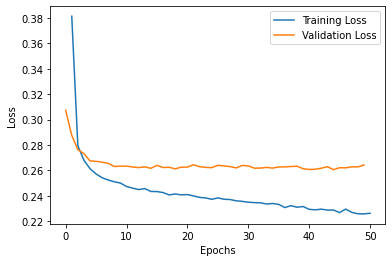

In [341]:
loss_values = history.history['loss']
vlloss_values = history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(vlloss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [348]:
model = get_model(n_inputs, n_outputs)
model.fit(x_train, y_train, verbose=0, epochs=18)

In [353]:
'''finding best threshold for the NN result'''
thresh =0.0
for _ in range (10):
  nn_y_pred = model.predict(xtest_tfw2v) 
  nn_y_pred = (nn_y_pred> thresh).astype(int)
  print(f"threshold: {thresh} --- score: {f1_score(ytest, nn_y_pred, average='micro')}")
  thresh += 0.05

threshold: 0.0 --- score: 0.22863421170165255
threshold: 0.05 --- score: 0.43414427629746544
threshold: 0.1 --- score: 0.5078224221617141
threshold: 0.15000000000000002 --- score: 0.550853212271289
threshold: 0.2 --- score: 0.5692369871402326
threshold: 0.25 --- score: 0.5826318607764391
threshold: 0.3 --- score: 0.5868038538447555
threshold: 0.35 --- score: 0.5742912467891721
threshold: 0.39999999999999997 --- score: 0.5573853327681222
threshold: 0.44999999999999996 --- score: 0.5342193725669796


In [360]:
nn_y_pred_trn = model.predict(xtrain_tfw2v)
nn_y_pred_tst = model.predict(xtest_tfw2v)

THRESHOLD = 0.3
nn_y_pred_trn = (nn_y_pred_trn >= THRESHOLD).astype(int)
nn_y_pred_tst = (nn_y_pred_tst >= THRESHOLD).astype(int)

In [363]:
print("*** NUERAL NET CLASSIFIER ***")
print(f"test set f-score: {f1_score(ytest_tfw2v, nn_y_pred_tst, average='micro')}")
print(f"test set roc-auc-score: {roc_auc_score(ytest_tfw2v, nn_y_pred_tst, average='micro')}")

*** NUERAL NET CLASSIFIER ***
test set f-score: 0.5868038538447555
test set roc-auc-score: 0.7910351147871884


These are the best scores we managed to achieve throughout all our tests!